In [2]:
import numpy as np
import pickle
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import KFold, ParameterGrid
import matplotlib.pyplot as plt

In [3]:
# File path
file_path = '/Users/jkli040526/Downloads/xordata (1).pkl'

# Load data
with open(file_path, 'rb') as f:
    data = pickle.load(f)

X = data['X_train']  # Input data
y = data['y_train'].reshape(-1, 1)  # Convert to column vector
X_test = data['X_test']
y_test = data['y_test'].reshape(-1, 1)


In [4]:
# Activation functions and their derivatives
def sigmoid(x):
    # Sigmoid activation function, used for the output layer
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    # Derivative of the sigmoid function, used during backpropagation
    return sigmoid(x) * (1 - sigmoid(x))

def relu(x):
    # ReLU activation function, used for the hidden layer
    return np.maximum(0, x)

def relu_derivative(x):
    # Derivative of the ReLU function, used during backpropagation
    return np.where(x > 0, 1, 0)


In [5]:
# Initialize parameters
def initialize_params(input_dim, hidden_dim, output_dim):
    # Initialize weights and biases for both layers with small random values
    np.random.seed(42)
    W1 = np.random.randn(input_dim, hidden_dim) * 0.01
    b1 = np.zeros((1, hidden_dim))
    W2 = np.random.randn(hidden_dim, output_dim) * 0.01
    b2 = np.zeros((1, output_dim))
    return W1, b1, W2, b2

In [6]:
# Forward propagation
def forward_propagation(X, W1, b1, W2, b2):
    # Compute activations for the hidden layer and output layer
    Z1 = np.dot(X, W1) + b1  # Linear step for hidden layer
    A1 = relu(Z1)  # Activation step for hidden layer
    Z2 = np.dot(A1, W2) + b2  # Linear step for output layer
    A2 = sigmoid(Z2)  # Activation step for output layer
    return Z1, A1, Z2, A2

# Backward propagation
def backward_propagation(X, y, Z1, A1, Z2, A2, W2):
    # Compute gradients for weights and biases using backpropagation
    m = X.shape[0]  # Number of training examples
    dA2 = A2 - y  # Gradient of loss with respect to A2
    dZ2 = dA2  # Derivative of sigmoid activation
    dW2 = np.dot(A1.T, dZ2) / m  # Gradient of W2
    db2 = np.sum(dZ2, axis=0, keepdims=True) / m  # Gradient of b2

    dA1 = np.dot(dZ2, W2.T)  # Gradient of A1
    dZ1 = dA1 * relu_derivative(Z1)  # Derivative of ReLU activation
    dW1 = np.dot(X.T, dZ1) / m  # Gradient of W1
    db1 = np.sum(dZ1, axis=0, keepdims=True) / m  # Gradient of b1

    return dW1, db1, dW2, db2
# Update parameters
def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate):
    # Update weights and biases using gradient descent
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2
    return W1, b1, W2, b2


In [7]:
# Train model
def train_model(X, y, input_dim, hidden_dim, output_dim, epochs, learning_rate, batch_size):
    # Train the neural network using mini-batch SGD
    W1, b1, W2, b2 = initialize_params(input_dim, hidden_dim, output_dim)
    loss_history = []
    for epoch in range(epochs):
        # Shuffle data to ensure randomness in mini-batch selection
        indices = np.arange(X.shape[0])
        np.random.shuffle(indices)
        X, y = X[indices], y[indices]

        # Mini-batch training
        for i in range(0, X.shape[0], batch_size):
            X_batch = X[i:i + batch_size]
            y_batch = y[i:i + batch_size]

            # Forward propagation
            Z1, A1, Z2, A2 = forward_propagation(X_batch, W1, b1, W2, b2)

            # Backward propagation
            dW1, db1, dW2, db2 = backward_propagation(X_batch, y_batch, Z1, A1, Z2, A2, W2)

            # Update parameters
            W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate)

        # Calculate loss for the epoch
        _, _, _, A2_full = forward_propagation(X, W1, b1, W2, b2)
        loss = -np.mean(y * np.log(A2_full + 1e-8) + (1 - y) * np.log(1 - A2_full + 1e-8))
        loss_history.append(loss)

    return W1, b1, W2, b2, loss_history
# Model prediction
def predict(X, W1, b1, W2, b2):
    # Predict the output for given input data using trained parameters
    _, _, _, A2 = forward_propagation(X, W1, b1, W2, b2)
    return (A2 > 0.5).astype(int)

In [8]:
# Hyperparameter grid
param_grid = {
    'hidden_dim': [5, 10, 20],  # Number of units in the hidden layer
    'learning_rate': [0.01, 0.05],  # Learning rate for gradient descent
    'batch_size': [16, 32],  # Batch size for mini-batch SGD
    'epochs': [500]  # Number of training epochs
}
grid = ParameterGrid(param_grid)

In [9]:
# Cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
best_params = None
best_accuracy = 0


In [10]:
# Iterate through all parameter combinations
for params in grid:
    fold_accuracies = []
    print(f"Testing params: {params}")

    # Perform K-Fold cross-validation
    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        # Train the model on the training fold
        W1, b1, W2, b2, _ = train_model(X_train, y_train, X_train.shape[1], params['hidden_dim'], 1,
                                     params['epochs'], params['learning_rate'], params['batch_size'])
        # Predict on the validation fold
        y_pred_val = predict(X_val, W1, b1, W2, b2)
        fold_accuracies.append(accuracy_score(y_val, y_pred_val))

    # Calculate mean accuracy for the current parameter set
    mean_accuracy = np.mean(fold_accuracies)
    print(f"Mean Validation Accuracy: {mean_accuracy:.4f}")

    # Update best parameters if current accuracy is better
    if mean_accuracy > best_accuracy:
        best_accuracy = mean_accuracy
        best_params = params


Testing params: {'batch_size': 16, 'epochs': 500, 'hidden_dim': 5, 'learning_rate': 0.01}
Mean Validation Accuracy: 0.6363
Testing params: {'batch_size': 16, 'epochs': 500, 'hidden_dim': 5, 'learning_rate': 0.05}
Mean Validation Accuracy: 0.6338
Testing params: {'batch_size': 16, 'epochs': 500, 'hidden_dim': 10, 'learning_rate': 0.01}
Mean Validation Accuracy: 0.9387
Testing params: {'batch_size': 16, 'epochs': 500, 'hidden_dim': 10, 'learning_rate': 0.05}
Mean Validation Accuracy: 0.9738
Testing params: {'batch_size': 16, 'epochs': 500, 'hidden_dim': 20, 'learning_rate': 0.01}
Mean Validation Accuracy: 0.9800
Testing params: {'batch_size': 16, 'epochs': 500, 'hidden_dim': 20, 'learning_rate': 0.05}
Mean Validation Accuracy: 0.9887
Testing params: {'batch_size': 32, 'epochs': 500, 'hidden_dim': 5, 'learning_rate': 0.01}
Mean Validation Accuracy: 0.6350
Testing params: {'batch_size': 32, 'epochs': 500, 'hidden_dim': 5, 'learning_rate': 0.05}
Mean Validation Accuracy: 0.6325
Testing para

In [11]:
# Output best hyperparameters
print("\nBest Parameters:")
print(best_params)
print(f"Best Cross-Validation Accuracy: {best_accuracy:.4f}")

# Evaluate best parameters on test set
W1, b1, W2, b2, loss_history = train_model(X_train, y_train, X_train.shape[1], best_params['hidden_dim'], 1,
                             best_params['epochs'], best_params['learning_rate'], best_params['batch_size'])
y_pred_test = predict(X_test, W1, b1, W2, b2)

# Output classification report on test set
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_pred_test, target_names=["Class 0", "Class 1"]))



Best Parameters:
{'batch_size': 16, 'epochs': 500, 'hidden_dim': 20, 'learning_rate': 0.05}
Best Cross-Validation Accuracy: 0.9887

Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        97
     Class 1       1.00      1.00      1.00       103

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



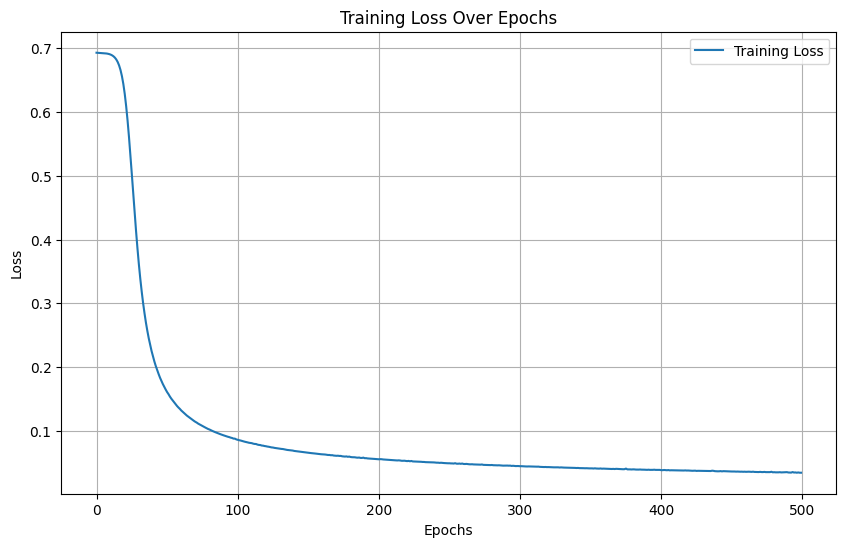

In [12]:
# Visualize loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(loss_history, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


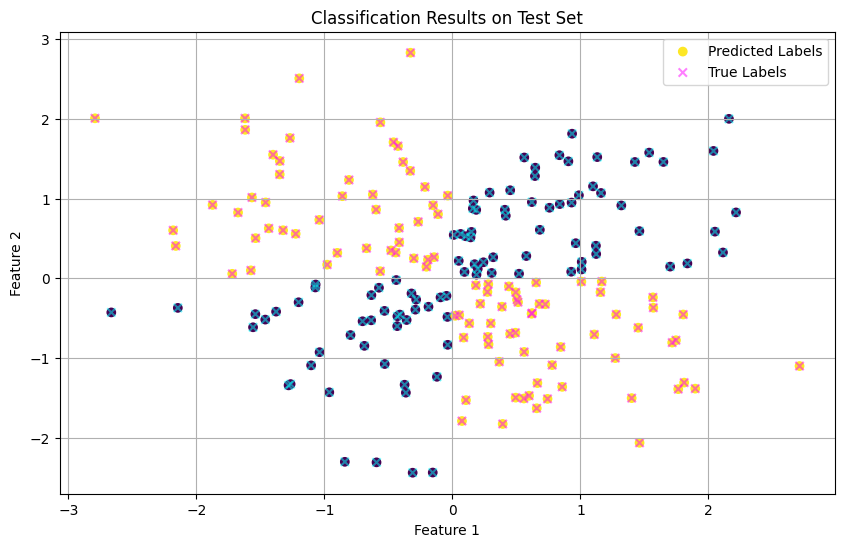

In [13]:
# Visualize classification results on test set
plt.figure(figsize=(10, 6))
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred_test.flatten(), cmap='viridis', marker='o', label='Predicted Labels')
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test.flatten(), cmap='cool', marker='x', alpha=0.5, label='True Labels')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Classification Results on Test Set')
plt.legend()
plt.grid(True)
plt.show()